# HowTo: Make a cross-section model with `ttim`
 
This HowTo describes how to make a cross-section model with `ttim`.

We start by importing the required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ttim as ttim

#
plt.rcParams["figure.figsize"] = (4, 3)  # set default figure size
plt.rcParams["font.size"] = 8  # set default font size

We will create an xsection model for a two-aquifer system with a river with a leaky river bottom (see Figure).
The model is divided in three sections: the left side of the river, the river, and the right side of the river.
The resistance of the top semi-confining layer is different than the resistance of the leaky river bottom. 
The aquifer parameters are defined in the table and code cell below. 

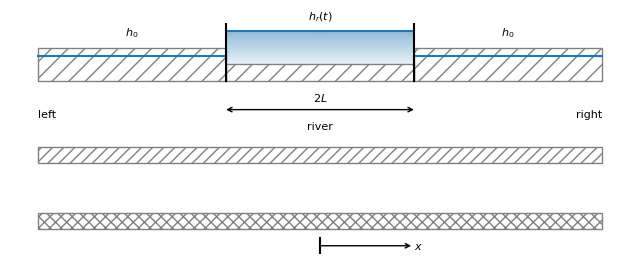

In [2]:
import matplotlib.colors as mcolors


def gradient_fill(x, y, fill_color="C0", ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0.1, 0.5, 100)[:, None]

    xmin, xmax, ymin, ymax = x[0], x[1], y[0], y[1]
    ax.imshow(
        z,
        aspect="auto",
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
    )


def arrow(xystart, xyend, text="", arrow="<-", color="k", **kwds):
    plt.annotate(
        text,
        xy=xystart,
        xytext=xyend,
        arrowprops={"arrowstyle": arrow, "shrinkA": 0, "shrinkB": 0, "color": color},
        color=color,
        **kwds,
    )


def solution12():
    plt.figure(figsize=(8, 3))

    plt.fill(
        [-0.1, 0.3, 0.3, -0.1],
        [0.8, 0.8, 1.2, 1.2],
        color="grey",
        fill=False,
        hatch="//",
    )
    plt.fill(
        [0.3, 0.7, 0.7, 0.3], [0.8, 0.8, 1.0, 1.0], color="grey", fill=False, hatch="//"
    )
    plt.fill(
        [0.7, 1.1, 1.1, 0.7], [0.8, 0.8, 1.2, 1.2], color="grey", fill=False, hatch="//"
    )

    plt.fill(
        [-0.1, 1.1, 1.1, -0.1],
        [0, 0, -0.2, -0.2],
        color="grey",
        fill=False,
        hatch="///",
    )
    plt.fill(
        [-0.1, 1.1, 1.1, -0.1],
        [-1, -1, -0.8, -0.8],
        color="grey",
        fill=False,
        hatch="xxx",
    )
    plt.plot([-0.1, 0.3], [1.1, 1.1], "C0")
    plt.plot([0.3, 0.7], [1.4, 1.4], "C0")
    plt.plot([0.7, 1.1], [1.1, 1.1], "C0")
    gradient_fill([0.3, 0.7], [1, 1.4])
    plt.plot([0.3, 0.3], [0.8, 1.5], "k")
    plt.plot([0.7, 0.7], [0.8, 1.5], "k")
    plt.text(0.1, 1.35, "$h_0$", ha="center")
    plt.text(0.5, 1.55, "$h_r(t)$", ha="center")
    plt.text(0.9, 1.35, "$h_0$", ha="center")
    plt.plot([0.5, 0.5], [-1.3, -1.1], "k")
    arrow((0.5, -1.2), (0.7, -1.2), "$x$", va="center")
    plt.text(-0.1, 0.4, "left", va="center")
    plt.text(0.5, 0.25, "river", va="center", ha="center")
    plt.text(1.1, 0.4, "right", ha="right", va="center")
    arrow((0.3, 0.45), (0.7, 0.45), arrow="<->")
    plt.text(0.5, 0.55, "$2L$", ha="center")
    plt.ylim(-1.3, 1.5)
    plt.axis("off")


solution12()  # plt.savefig('riverxsection.svg')

| Parameter            | left/right | river |
| :------------: | :------: | ----: |
| $c_0$ (d)      |   500    | 200 |
| $k_0$ (m/d)    |   10     | 10 |
| $S_{s0}$ (m$^{-1}$)    |   1e-4     | 1e-4 |
| $c_1$ (d)      |  1000    | 1000 |
| $k_1$ (m/d)    |   20     | 20|
| $S_{s1}$ (m$^{-1}$)    |   1e-4     | 1e-4 |

In [3]:
zside = [2, 0, -10, -12, -22]  # elevation of top and bottoms of layers, m
zriver = [1, 0, -10, -12, -22]  # elevation of top and bottoms of layers, m
cside0 = 500  # resistance of top semi-confining layer, d
criver0 = 200  # resistance of leaky river bottom, d
k0 = 10  # hydraulic conductivity of first aquifer, m/d
Ss0 = 1e-4  # specific storage of first aquifer, m^(-1)
c1 = 1000  # resistance of leaky layer between aquifers, d
k1 = 20  # hydraulic conductivity of second aquifer, m/d
Ss1 = 1e-4  # specific storage of second aquifer, m^(-1)
L = 50  # half width of river, m

An cross-sectional model is created with two aquifer layer, 
and is stored in the variable `ml`. Next, `XsectionMaq` sections are defined for the three sections of the model. Make sure that the entire cross-section is covered by an `XsectionMaq`. The head above the semi-confining top is fixed on the left and right side, which means that the head change equals zero. The head in the river varies with time and is specified with the `tsandhstar` keyword. `tsandhstar` must be a list of 2-tuples, where each tuple consists of `(time, head in river starting at that time)`.  Alternatively, `tsandhstar` can be an array with $N$ rows and two columns, where $N$ is the number of times that a different water level in the river is specified. 

In [4]:
ml = ttim.ModelXsection(naq=2, tmin=1e-3, tmax=1e2)

ttim.XsectionMaq(
    model=ml,
    x1=-np.inf,
    x2=-L,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[cside0, c1],
    topboundary="semi",
    name="left",
)

ttim.XsectionMaq(
    model=ml,
    x1=-L,
    x2=L,
    kaq=[k0, k1],
    z=zriver,
    Saq=[Ss0, Ss1],
    c=[criver0, c1],
    topboundary="semi",
    tsandhstar=[(0, 1)],
    name="river",
)

ttim.XsectionMaq(
    model=ml,
    x1=L,
    x2=np.inf,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[cside0, c1],
    topboundary="semi",
    name="right",
)

ml.solve()  # solve the model

self.neq  8
solution complete


Compute the head at 100 points in space between $-200$ and $+200$ for 5 times

In [5]:
ng = 100
nt = 5
x = np.linspace(-200, 200, ng)
y = np.zeros(ng)
t = np.logspace(-2, 1, nt)
h = ml.headalongline(x, y, t)

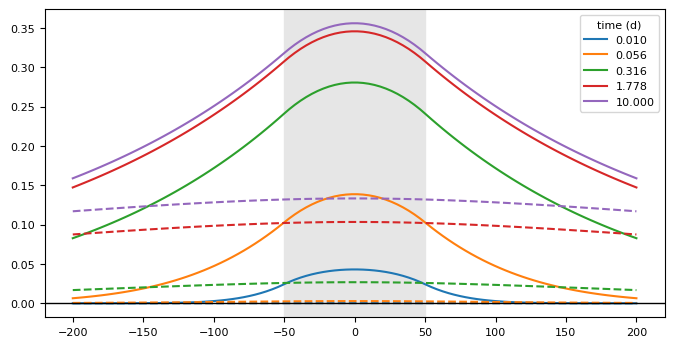

In [6]:
plt.figure(figsize=(8, 4))
for i, itime in enumerate(range(5)):
    plt.plot(x, h[0, itime], "C" + str(i), label=f"{t[itime]:.3f}")
    plt.plot(x, h[1, itime], "C" + str(i), ls="--")
plt.legend(title="time (d)")
plt.axhline(0, color="k", lw=1)
plt.axvspan(-L, L, color=[0.9, 0.9, 0.9]);

Compute and plot the head at $x=50$ for time varying from 0.001 to 10 with 99 steps, equall spaced in log-space.

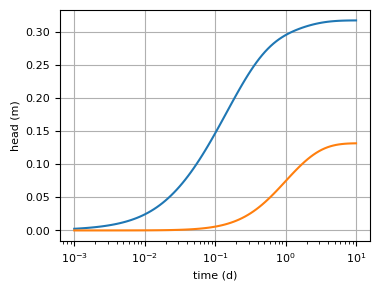

In [7]:
nt = 100
t = np.logspace(-3, 1, nt)
h = ml.head(x=50, y=0, t=t)
plt.semilogx(t, h[0])
plt.semilogx(t, h[1])
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.grid()

### Sythetic calibration example
A synthetic example is presented 
The head in the river is varied 20 times (daily) over a period of 20 days. 

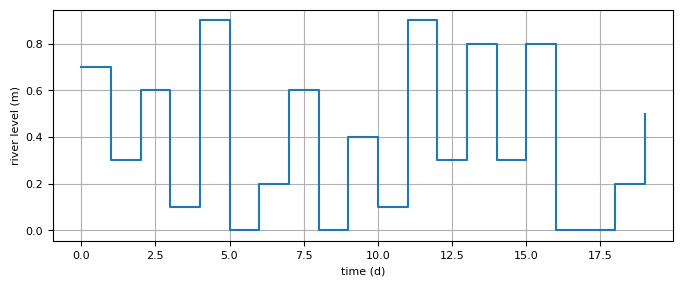

In [8]:
ts = np.arange(0, 20)
rng = np.random.default_rng(seed=22)
hstar = rng.integers(low=0, high=10, size=20) * 0.1
tsandh = list(zip(ts, hstar, strict=True))
plt.figure(figsize=(8, 3))
plt.step(ts, hstar, where="post")
plt.xlabel("time (d)")
plt.ylabel("river level (m)")
plt.grid()

The head is computed at $x=50$ in the top aquifer from day 10 till day 20 with intervals of 0.1 day. This is the synthetic truth. A normally distributed error is added to the synthetic truth and this is called the (synthetic) observed head `hsyn`, which is plotted. 

self.neq  8
solution complete


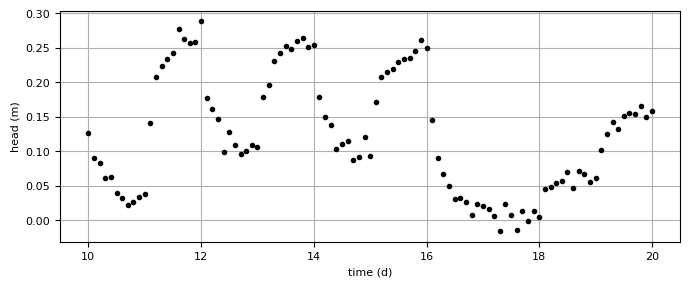

In [9]:
ml = ttim.ModelXsection(naq=2, tmin=1e-3, tmax=1e2)

ttim.XsectionMaq(
    model=ml,
    x1=-np.inf,
    x2=-L,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[cside0, c1],
    topboundary="semi",
    name="left",
)

ttim.XsectionMaq(
    model=ml,
    x1=-L,
    x2=L,
    kaq=[k0, k1],
    z=zriver,
    Saq=[Ss0, Ss1],
    c=[criver0, c1],
    topboundary="semi",
    tsandhstar=tsandh,
    name="river",
)

ttim.XsectionMaq(
    model=ml,
    x1=L,
    x2=np.inf,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[cside0, c1],
    topboundary="semi",
    name="right",
)

ml.solve()

tsyn = np.linspace(10, 20, 101)
xsyn = 50
hexact = ml.head(xsyn, 0, tsyn, layers=0)
hsyn = hexact[0] + 0.01 * rng.standard_normal(len(tsyn))
#
plt.figure(figsize=(8, 3))
plt.plot(tsyn, hsyn, "k.", label="layer 0")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.grid()

Next, we pretend that we don't quite know the resistance of the semi-confining layer on the left and right sides nor do we know the resistance of the leaky river bed. We will create a `ttim` model and use the observed head to 
calibrate the model and estimate the resistance of the semi-confining layer the leaky stream bed. As as first guess, we use $c=100$ d for both.

In [10]:
crivguess = 100.0
csideguess = 100.0

ml = ttim.ModelXsection(naq=2, tmin=1e-3, tmax=1e2)

ttim.XsectionMaq(
    model=ml,
    x1=-np.inf,
    x2=-L,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[csideguess, c1],
    topboundary="semi",
    name="left",
)

ttim.XsectionMaq(
    model=ml,
    x1=-L,
    x2=L,
    kaq=[k0, k1],
    z=zriver,
    Saq=[Ss0, Ss1],
    c=[crivguess, c1],
    topboundary="semi",
    tsandhstar=tsandh,
    name="river",
)

ttim.XsectionMaq(
    model=ml,
    x1=L,
    x2=np.inf,
    kaq=[k0, k1],
    z=zside,
    Saq=[Ss0, Ss1],
    c=[csideguess, c1],
    topboundary="semi",
    name="right",
)

right: XsectionMaq [50, inf]

Next, we create a `Calibrate` object for the model. We add the series to use for calibration. Next, we add two parameters to be calibrated. The first one on the resistance of the leaky stream bed. The second one is the resistance of the semi-confining layer on the left and right sides; the same value is used for both sides by specifying `inhoms=("left", "right")`. Note that the inhoms are specified by the name (string) used to create them. Finally, the model is calibrated using the `fit` function. 

In [11]:
cal = ttim.Calibrate(ml)
cal.series(
    name="synthetic",
    x=xsyn,
    y=0,
    layer=0,
    t=tsyn,
    h=hsyn,
)

cal.set_parameter(
    name="c",
    layers=[0],
    initial=12,
    pmin=1.0,
    pmax=1000.0,
    inhoms=("river"),
)

cal.set_parameter(
    "c",
    layers=[0],
    initial=csideguess,
    pmin=1.0,
    pmax=1000.0,
    inhoms=("left", "right"),
)

cal.fit(report=True)

.............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 101
    # variables        = 2
    chi-square         = 0.01077326
    reduced chi-square = 1.0882e-04
    Akaike info crit   = -919.726682
    Bayesian info crit = -914.496441
[[Variables]]
    c_river:       198.354633 +/- 4.77943674 (2.41%) (init = 12)
    c_left_right:  521.772791 +/- 31.6324449 (6.06%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_river, c_left_right) = +0.9057


All inhomogeneities are stored in a dictionary `inhomdict`, which is stored in `ml.aq`. For example, the resistance of the leaky layer on the left and right side of the river may be retrieved as follows.

In [12]:
print("resistance values on left side:  ", ml.aq.inhomdict["left"].c)
print("resistance falues on right side: ", ml.aq.inhomdict["right"].c)

resistance values on left side:   [ 521.7727914 1000.       ]
resistance falues on right side:  [ 521.7727914 1000.       ]


Finally, the fitted head is plotted together with the 'observed' heads and the 'truth'. 

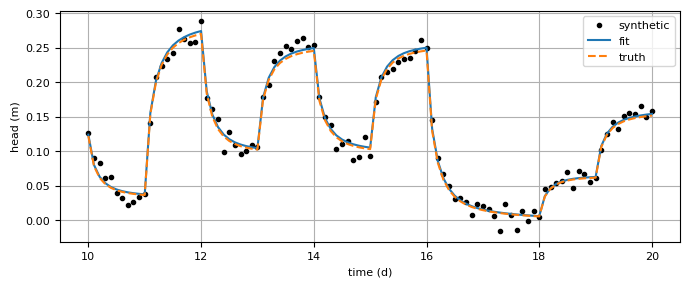

In [13]:
hmodel = ml.head(xsyn, 0, tsyn, 0)
plt.figure(figsize=(8, 3))
plt.plot(tsyn, hsyn, "k.", label="synthetic")
plt.plot(tsyn, hmodel[0], label="fit")
plt.plot(tsyn, hexact[0], "--", label="truth")
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()